# Real-time Tweet Counter - Eurovision Song Contest 2022 - 2nd Semifinal 
**GOAL**: Detect the amount of tweets sent every 5 minutes containing the hashtag #**Eurovision** during the second semi-final live show.

**NOTES**:
* The live show starts at **8.30 P.M. CET** on May 12, 2022. The analysis will start from that moment.

## Libraries

In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.streaming import StreamingContext
from time import time
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Variables

In [14]:
BATCH_DURATION = 300
PORT = 9999
hostname = "localhost"
fig_save = "res/esc.jpg"
pd_save = "res/esc.csv"

## RDD Processing

In [3]:
counter_list = []
time_list = []

def process_rdd(time, rdd):
    counter_list.append(rdd.first())
    time_list.append(time)

## Streaming Context

In [4]:
sc = SparkContext.getOrCreate()
ssc = StreamingContext(sc, BATCH_DURATION)
lines = ssc.socketTextStream(hostname, PORT)

## Timestamp

In [5]:
def format_timestamp(x):
    return x.strftime("%Y-%m-%d %H:%M:%S")

In [6]:
def print_timedelta(date_start):
    print("Start tweet analysis: " + format_timestamp(date_start))
    date_now = dt.datetime.now()
    print("Last update: " + format_timestamp(date_now))
    delta = date_now - date_start
    delta_seconds = delta.seconds
    delta_hours = delta_seconds/3600
    delta_minutes = (delta_seconds/60)%60
    delta_seconds = delta_seconds%60
    if delta.days!=0:
        print("Elapsed time: %d days, %d hours, %d minutes, %d seconds" 
                % (delta.days, delta_hours, delta_minutes, delta_seconds))
    else:
        print("Elapsed time: %d hours, %d minutes, %d seconds" 
                % (delta_hours, delta_minutes, delta_seconds))

## Discretized stream

In [7]:
lines.count().foreachRDD(process_rdd)

## Start Streaming

In [8]:
ssc.start()

print("Starting tweeet analysis...")
start = dt.datetime.now()

Starting tweeet analysis...


## Tweet counter

Start tweet analysis: 2022-05-12 20:29:05
Last update: 2022-05-12 23:45:12
Elapsed time: 3 hours, 16 minutes, 6 seconds


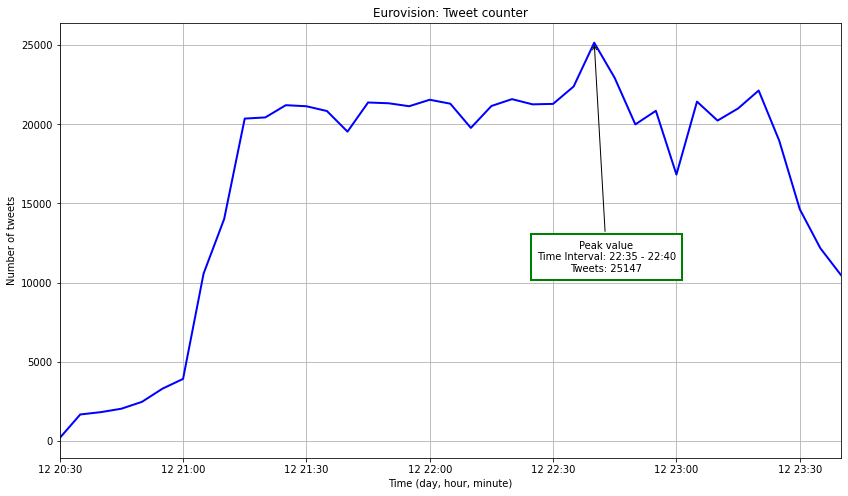

Total tweets: 644484
Average of tweets per batch (5 minutes): 16525


In [43]:
print_timedelta(start)

# Save the counter per batch
counter_pd = pd.DataFrame({"Time": time_list,"Count": counter_list})
counter_pd.to_csv(pd_save)

x = time_list
y = counter_list

fig, ax = plt.subplots()
ax.plot(x,y, color='blue', lw=2)
plt.rcParams['figure.figsize'] = [14,8]
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0.05
plt.title("Eurovision: Tweet counter")
plt.xlabel("Time (day, hour, minute)")
plt.ylabel("Number of tweets")
plt.grid()

# Max value
ymax = max(y)
max_index = y.index(ymax)
xmax = x[max_index]
text_max = "Peak value\nTime Interval: {prev_max} - {xmax}\nTweets: {ymax}" \
                .format(prev_max=x[max_index-1].strftime("%H:%M"),
                        xmax=xmax.strftime("%H:%M"), 
                        ymax=ymax)
bbox_props = dict(boxstyle="square,pad=0.6", fc="w", ec="green", lw=2)
arrowprops=dict(arrowstyle="->",connectionstyle="arc3, rad=0")
kw = dict(xycoords='data',textcoords="axes fraction",
          arrowprops=arrowprops, bbox=bbox_props, ha="center", va="top")
ax.annotate(text_max, xy=(xmax, ymax), xytext=(0.70,0.50), **kw)

plt.savefig(fig_save)
plt.show()

counter_np = np.array(counter_list)
print("Total tweets: %d" % sum(counter_list))
print("Average of tweets per batch (5 minutes): %d" % np.mean(counter_np))